# System tools to herd the dumps into something useful

In [1]:
%pylab nbagg

import os
import re

from topas2numpy import read_ntuple
from datetime import datetime
from pylab import figure, cm
from matplotlib.colors import LogNorm

Populating the interactive namespace from numpy and matplotlib


## Making a new analysis directory

In [4]:
now = datetime.now()

dt_string = now.strftime("%Y-%m-%d-h%Hm%M")

print(dt_string)

os.mkdir(f'analysis/{dt_string}')

2020-08-24-h10m01


## Reformat the dump

In [102]:
!rename -e 's/\d+/sprintf("%04d",$&)/e' -- *.csv
!ls *.csv | grep -o '[0-9][0-9]*' > energies.txt
!cat *.csv | awk 'NR % 6 == 0' > deposition.txt
!rename -e 's/\d+/sprintf("%04d",$&)/e' -- *.phsp
!rename -e 's/\d+/sprintf("%04d",$&)/e' -- *.header

In [4]:
#!cat energies.txt deposition.txt
#!cat deposition.txt

In [103]:
with open('energies.txt') as f:
    energies = np.array([[x for x in line.split()] for line in f]).astype(np.float).flatten()
    
with open('deposition.txt') as f:
    array = np.array([[x for x in line.split()] for line in f]).flatten()
    deposition = array.astype(np.float)

In [104]:
np.save(f'analysis/{dt_string}/EnergyDeposition.npy',[deposition,energies])

<IPython.core.display.Javascript object>


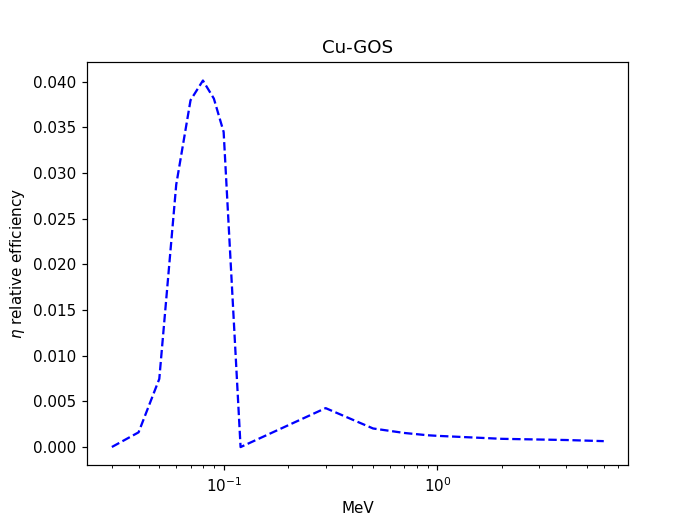

Text(0.5, 1.0, 'Cu-GOS')

In [105]:
plt.figure()
plt.semilogx(energies/1000,deposition/(energies/1000)/3000000,'b--')
plt.xlabel('MeV')                                                       
plt.ylabel('$\eta$ relative efficiency')
# plt.savefig(f'analysis/{dt_string}/EnergyDeposition.png')
plt.title('Cu-GOS')

<IPython.core.display.Javascript object>


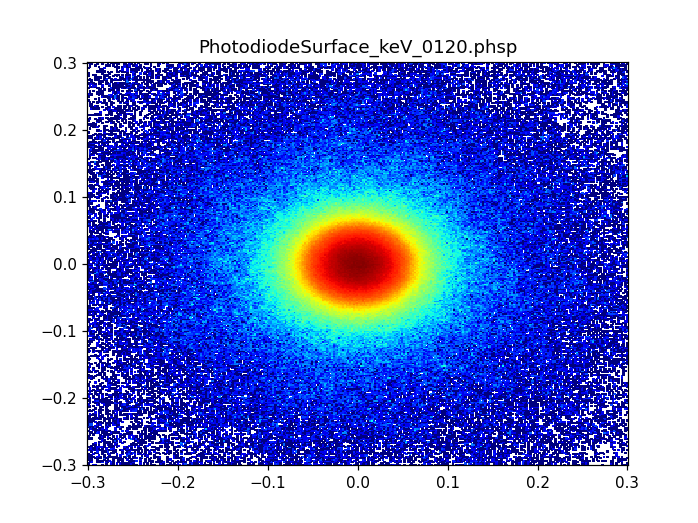

In [10]:
rootdir = "."
regex = re.compile('(.*120.phsp$)|(.*rar$)|(.*r01$)')

phase_spaces = []
plt.figure()

# xedges = np.linspace(-1.5876+0.0196,1.5876-0.0196,40) # Changed from 82 JO 2020 07
# yedges = np.linspace(-1.5876+0.0196,1.5876-0.0196,40) # Changed from 40 JO 08


# edges_forward = (np.arange(0.0392,81*0.0782,0.0782))

# edges_forward = (np.arange(0.0196,41*0.0392,0.0392))

# edges_forward = (np.arange(0.0168,41*0.0336,0.0336))

edges_forward = (np.arange(0.001,151*0.002,0.002))

edges = np.hstack([-1*edges_forward[-1::-1], edges_forward])

xedges = edges #np.linspace(-2,2,201) # Changed from 82 JO 2020 07
yedges = edges #np.linspace(-2,2,201) # Changed from 40 JO 08

for root, dirs, files in os.walk(rootdir):
    for file in files:
        if regex.match(file):
            
            y = read_ntuple(os.path.join(rootdir,file))
#             xx = [y[kk][0] for kk in range(y.size)]
#             yy = [y[kk][1] for kk in range(y.size)]
            
            h,xs,yx,ima = plt.hist2d(y['Local position X [cm]'],y['Local position Y [cm]'], bins = [xedges,yedges], cmap=cm.jet, norm=LogNorm())
            plt.title(f'{file}')
#             plt.savefig(f'analysis/{dt_string}/{file}.png')
            
#             np.save(f'analysis/{dt_string}/{file}',h)


In [75]:
# lsf2 = h[40,:]
lsf = h[150,:]

<IPython.core.display.Javascript object>


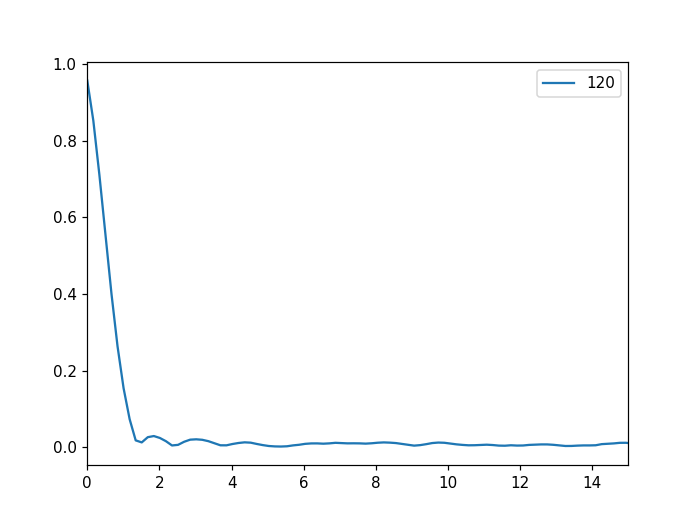

(0.0, 15.0)

In [76]:
# mtf = np.absolute(np.fft.fft(np.convolve(lsf,[0.2]*5)))
# mtf_final = np.fft.fftshift(mtf)

# N = len(mtf)

# T = 0.01

# xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

# mm = np.argmax(mtf_final)
# plt.figure()
# plt.plot(mtf_final[mm:]/mtf_final[mm])

mtf = np.absolute(np.fft.fft(lsf))
mtf_final = np.fft.fftshift(mtf)

N = len(mtf)

T = 0.02

xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

mm = np.argmax(mtf_final)

plt.figure()
plt.plot(xf,mtf_final[mm+1:]/mtf_final[mm])
plt.legend(['120','6000'])
plt.xlim([0,15])

# mtf = np.absolute(np.fft.fft(lsf2))
# mtf_final = np.fft.fftshift(mtf)

# N = len(mtf)

# T = 0.0336

# xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

# mm = np.argmax(mtf_final)

# # plt.figure()
# plt.plot(xf,mtf_final[mm+1:]/mtf_final[mm])
# plt.legend(['120','6000'])
# plt.xlim([0,15])

In [49]:
len(xf[:mm+1])

150

In [51]:
len(xf)

150

<IPython.core.display.Javascript object>


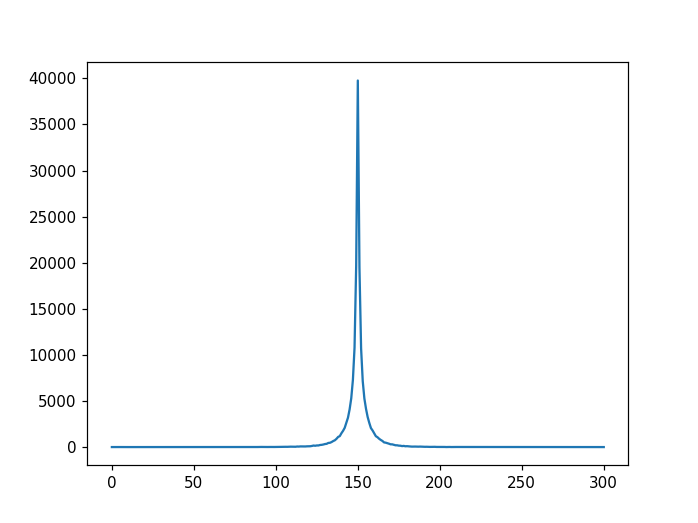

In [67]:
plt.figure()
plt.plot(h[150,:])
# plt.plot(h[41,:])
# plt.plot(h[42,:])

In [ ]:
from PIL import Image
import glob

# Create the frames
frames = []
imgs = sorted(glob.glob("analysis/2020-06-03-h14m33/*.png"))

for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

In [10]:
!cat ~/anaconda3/lib/python3.7/site-packages/topas2numpy/ntuple.py

# -*- coding: utf-8 -*-

# system imports
import re
import os.path

# third-party imports
import numpy as np

re_uint = '\d+'
re_str = '[\S+ \t]+'

binary_old_int_columns = [
    'Particle Type (in PDG Format)',
    'Run ID',
    'Event ID',
    'Track ID',
    'Parent ID',
    'Seed Part 1',
    'Seed Part 2',
    'Seed Part 3',
    'Seed Part 4',
]

limited_col_names = [
    ('Particle Type (sign from z direction)', np.int8),
    ('Energy (MeV) (-ve if new history)', 'f'),
    ('Position X (cm)', 'f'),
    ('Position Y (cm)', 'f'),
    ('Position Z (cm)', 'f'),
    ('Direction Cosine X', 'f'),
    ('Direction Cosine Y', 'f'),
    ('Weight', 'f'),
]


def read_ntuple(filepath):
    root, ext = os.path.splitext(filepath)
    ntuple_path = root + '.phsp'
    header_path = root + '.header'

    file_format, col_names = _sniff_format(header_path)

    if file_format == 'ascii':
        # preserve column names => cannot be viewed as a np.recarray
        # http://docs.scipy.org/doc/numpy-1

In [11]:
file

'PhotodiodeSurface_keV_6000.phsp'

In [12]:
!pwd

/home/xcite/topas/scintillators/Cu-GOS/runs


In [13]:
68372568/2848857

24.0

In [14]:
150398688/6266612

24.0

In [15]:
7437024/24

309876.0

In [36]:
xedges = np.linspace(-1.5876+0.0196,1.5876-0.0196,41)

(max(xedges) - min(xedges))/40

0.0784

In [34]:
0.25*0.784

0.196